In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
sys.path.append('../utils')
import discriminative_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
def generate_dataset(num_classes, instances_per_class, class_copy_percentage, kmer_presence_rate, random_state):
    """
    Generates a simulated dataset with a specified percentage of classes having one copy each,
    ensuring the exact presence rate of the discriminative k-mer in each class.
    
    Parameters:
    - num_classes : Number of unique classes in the dataset.
    - instances_per_class : Number of instances per class.
    - class_copy_percentage : Percentage of the classes that will have one copy each.
    - kmer_presence_rate : Exact presence rate of the discriminative k-mer in each class (0.0 to 1.0).
    - random_state : int or None, seed for the random number generator for reproducibility.
    
    Returns:
    - X : Feature matrix, where each feature represents a k-mer.
    - y : Class label vector, with unique labels for each class and its one copy.
    """
    rng = np.random.default_rng(random_state)  # Create a random number generator with a given seed

    # Determine how many classes will actually have copies
    num_classes_with_copies = int(num_classes * class_copy_percentage)
    selected_classes = rng.choice(num_classes, num_classes_with_copies, replace=False)

    # Calculate total instances including one copy per selected class
    total_instances = num_classes * instances_per_class + num_classes_with_copies * instances_per_class
    X = np.zeros((total_instances, num_classes))  # Feature matrix
    y = np.zeros(total_instances)  # Class labels
    
    current_index = 0

    # Fill original class instances
    for class_idx in range(num_classes):
        kmer_count = int(instances_per_class * kmer_presence_rate)  # Calculate exact number of instances to have k-mers
        kmer_indices = rng.choice(instances_per_class, kmer_count, replace=False)  # Select which instances will have k-mers

        for instance_idx in range(instances_per_class):
            start_idx = current_index
            if instance_idx in kmer_indices:  # Set k-mer presence based on pre-determined indices
                X[start_idx, class_idx] = 1
            y[start_idx] = class_idx  # Original class label
            current_index += 1
        
        # Generate one copy if the class is selected to have copies
        if class_idx in selected_classes:
            for instance_idx in range(instances_per_class):
                start_idx = current_index
                X[start_idx, :] = X[start_idx - instances_per_class, :]  # Copy the feature vector from the original class
                y[start_idx] = num_classes + class_idx  # New unique label for the copy
                current_index += 1

    return X, y

In [3]:
def perform_grid_search():
    """Perform grid search over specified parameter ranges and store results."""
    results = []
    random_state = 42
    instances_per_class = 100
    for num_classes in num_classes_options:
        for class_copy_percentage in class_copy_percentage_options:
            param_iter = [(k,) for k in kmer_presence_rate_options]

            for (kmer_presence_rate,) in param_iter:
                # Generate dataset with percentage of classes copied
                X, y = generate_dataset(num_classes, instances_per_class, class_copy_percentage, kmer_presence_rate, random_state)
                # Evaluate model and record results
                categorized_scores, uncategorized_scores = discriminative_score.get_discriminative_scores(X, y)
                f1_macro, f1_micro, f1_weighted, wqmf1_score = categorized_scores[0], categorized_scores[1], categorized_scores[2], categorized_scores[3]
                results.append((num_classes, class_copy_percentage, kmer_presence_rate, f1_macro, f1_micro, f1_weighted, wqmf1_score))
    return results

# Parameter ranges
num_classes_options = [2, 4, 8, 16, 32, 50]
class_copy_percentage_options = [0.0, 0.25, 0.5, 0.75, 1.0]
kmer_presence_rate_options = [1.00, 0.75, 0.50, 0.25]

# Perform grid search
results = perform_grid_search()

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(results, columns=['Num Classes', 'Class Copy Percentage', 'Kmer Presence Rate', 'Macro F1', 'Micro F1', 'Weighted F1', 'RMS Rank-Weighted F1'])

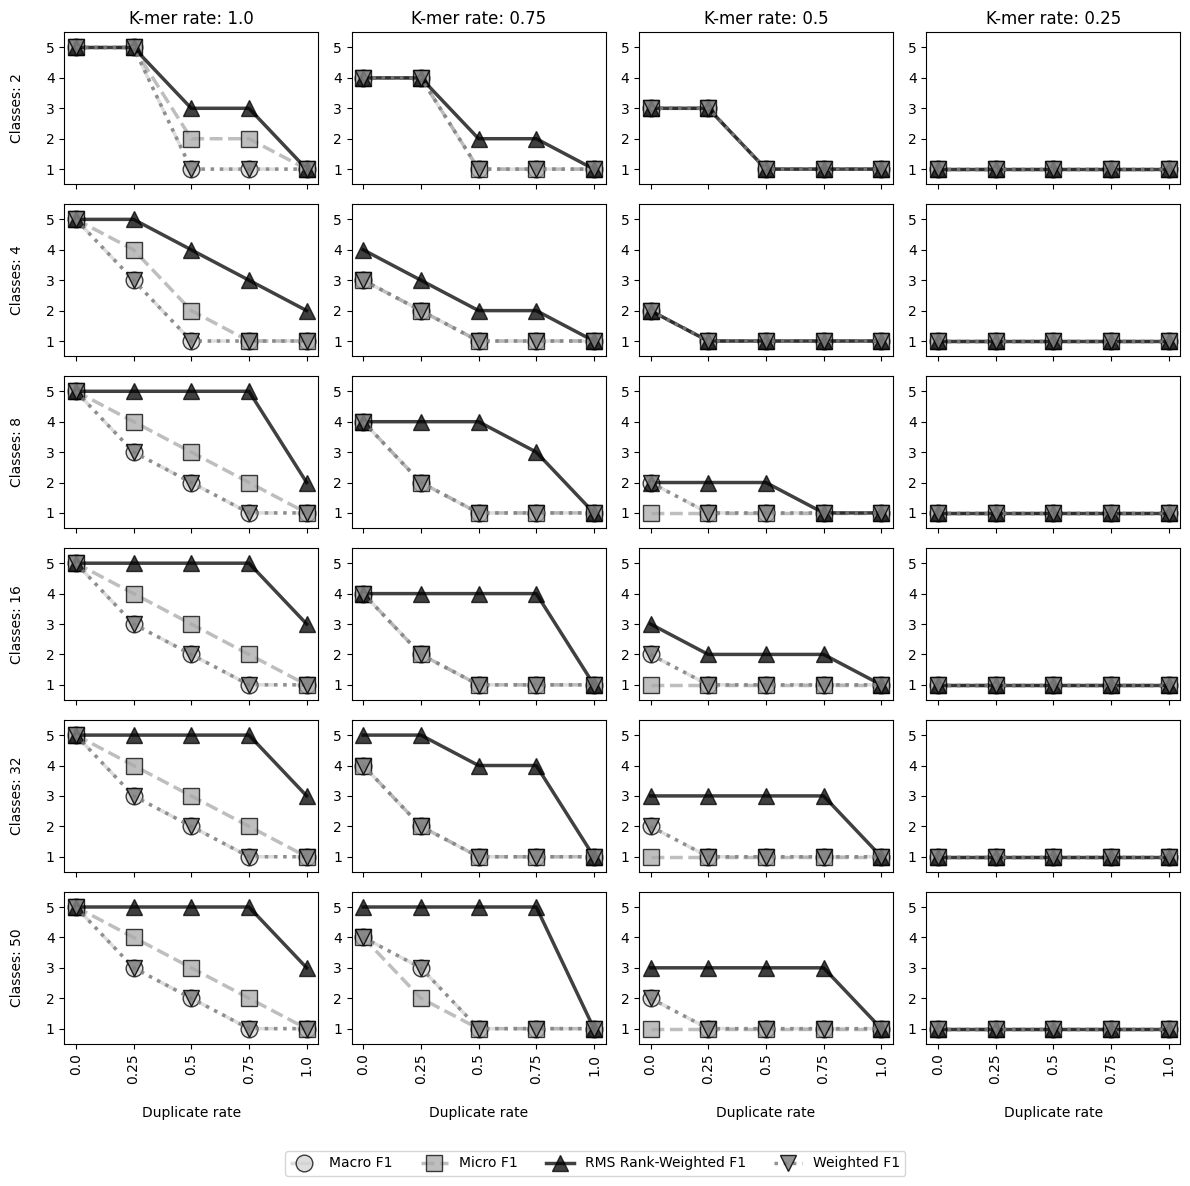

: 

In [12]:
# Group the data by 'Num Classes' for subplots
grouped = results_df.groupby('Num Classes')
num_rows = len(grouped)
num_cols = len(kmer_presence_rate_options)

# Define specific parameters for each score type explicitly
colors =     {'Macro F1': 'lightgray',    'Micro F1': 'darkgray',  'Weighted F1': 'grey', 'RMS Rank-Weighted F1': 'black'}
markers =    {'Macro F1': 'o',       'Micro F1': 's',      'Weighted F1': 'v',      'RMS Rank-Weighted F1': '^'}
linestyles = {'Macro F1': 'dashdot', 'Micro F1': 'dashed', 'Weighted F1': 'dotted', 'RMS Rank-Weighted F1': 'solid'}
alphas =     {'Macro F1': 0.75,      'Micro F1': 0.75,     'Weighted F1':0.85,      'RMS Rank-Weighted F1': 0.75}

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 2 * num_rows), squeeze=False)

for idx, (num_classes, group) in enumerate(grouped):
    for j, kmer in enumerate(kmer_presence_rate_options):
        filtered_group = group[group['Kmer Presence Rate'] == kmer].copy()
        filtered_group['Experiment Description'] = filtered_group['Class Copy Percentage'].apply(lambda x: f'{x}')
        melted_df = filtered_group.melt(id_vars=['Experiment Description'], value_vars=['Macro F1', 'Micro F1', 'Weighted F1', 'RMS Rank-Weighted F1'], var_name='Score Type', value_name='Score')
        ax = axes[idx][j]

        # Plotting with matplotlib directly using color mappings
        for score_type, data in melted_df.groupby('Score Type'):
            ax.plot(data['Experiment Description'], data['Score'], label=score_type, 
                                                                   marker=markers[score_type],
                                                                   markersize=12,
                                                                   linestyle=linestyles[score_type],
                                                                   linewidth=2.5, 
                                                                   color=colors[score_type], 
                                                                   alpha= alphas[score_type],  
                                                                   markeredgewidth=1, 
                                                                   markeredgecolor='black') 

        if idx == 0: ax.set_title(f'K-mer rate: {kmer}')
        if idx == num_rows - 1: ax.set_xlabel('\nDuplicate rate')
        ax.set_xticks(np.arange(len(filtered_group['Experiment Description'])))
        ax.set_xticklabels(filtered_group['Experiment Description'] if idx == num_rows - 1 else [], rotation=90)
        ax.set_ylabel(f'Classes: {num_classes}\n' if j == 0 else '')
        ax.set_ylim(0.5, 5.5)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=4, fontsize='medium')
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("discriminative_score_simulated_data_figure.pdf", dpi=300)
plt.show()